In [43]:
using Pkg
Pkg.activate(".")


  Activating project at `~/workspace/uni/spatial_temporal_data/spatio_temporal_data-rainforest_development`


In [44]:
include("src/rainforest_lib.jl")
using .Rainforestlib


In [45]:
using Zarr
using YAXArrays

lc = Rainforestlib.get_lcc_datacube()

filtered_dc = Rainforestlib.rough_spatial_filter(lc; time_bounds = (Date(2010), Date(2021)))

small_soy_region_dc = Rainforestlib.rough_spatial_filter(
    lc;
    lon_bounds = (-57, -54),
    lat_bounds = (-10, -6), 
    time_bounds = (Date(2010), Date(2021))
)

YAXArray with the following dimensions
lon                 Axis with 135 Elements from -56.998611111111096 to -54.02083333333332
lat                 Axis with 180 Elements from -6.020833333333328 to -9.998611111111106
time                Axis with 11 Elements from 2010-01-01T00:00:00 to 2020-01-01T00:00:00
name: lccs_class
Total size: 261.04 KB


In [46]:
include("src/LCCSClasses.jl")
using .LCCSClasses

# set a set of accepted values
rainforest_values = Set(LCCSClasses.categories["rainforest"].lccs_classes)

forest_values = Set(LCCSClasses.categories["forest"].lccs_classes)

all_forest_values = union(forest_values, rainforest_values)

Set{String} with 13 elements:
  "tree_needleleaved_evergreen_open"
  "tree_needleleaved_deciduous_closed"
  "tree_needleleaved_deciduous_open"
  "tree_needleleaved_deciduous_closed_to_open"
  "tree_broadleaved_deciduous_open"
  "tree_broadleaved_deciduous_closed"
  "tree_broadleaved_evergreen_closed_to_open"
  "tree_cover_flooded_saline_water"
  "tree_needleleaved_evergreen_closed"
  "tree_mixed"
  "tree_broadleaved_deciduous_closed_to_open"
  "tree_cover_flooded_fresh_or_brakish_water"
  "tree_needleleaved_evergreen_closed_to_open"

In [ ]:
# WARNING: do not try this with the huge datacube, it wont work. The in function needs to be ported to datacubes, the native one is not working
# to create the world map, simply set local_map=false
global_figure = Rainforestlib.build_figure_by_lcc_classes(lc, rainforest_values; local_map = false, set_nan = true)

In [ ]:
using .Rainforestlib

# local is the default, and makes the map as large as the datapoints
# but can me changed by setting 

using Colors, ColorSchemes

custom_colormap = [
    RGB(1.0, 1.0, 1.0),  # Red
    RGB(0.0, 0.0, 1.0),  # Blue
    RGB(0.0, 1.0, 0.0)   # Green
]

local_figure = Rainforestlib.build_figure_by_lcc_classes(small_soy_region_dc, all_forest_values; colormap = custom_colormap, colorrange = (0,1), set_nan = true)

In [ ]:
using .Rainforestlib

local_figure = Rainforestlib.build_figure_all_classes(filtered_dc; set_nan = true)

In [ ]:
Rainforestlib.build_plots_over_time(filteset_nanred_dc, all_forest_values; resolution=(2000, 2000), set_nan = true)

In [6]:
# build one figure with diffs for each timestep

Rainforestlib.build_diff_figures_over_time(small_soy_region_dc, Rainforestlib.LCCSClasses.categories["rainforest"], "imgs"; name_base = "diff_first_year_small_soy_region", resolution = (3000, 3000))


Number of rainforest pixels in 2010-01-01T00:00:00: 1.325171e6


┌ Warning: Could not find font regular, using TeX Gyre Heros Makie
└ @ Makie ~/.julia/packages/Makie/iECbF/src/conversions.jl:993


Number of rainforest pixels in 2011-01-01T00:00:00: 1.324896e6
Number of rainforest pixels in 2012-01-01T00:00:00: 1.324261e6
Number of rainforest pixels in 2013-01-01T00:00:00: 1.32273e6
Number of rainforest pixels in 2014-01-01T00:00:00: 1.322726e6
Number of rainforest pixels in 2015-01-01T00:00:00: 1.322725e6
Number of rainforest pixels in 2016-01-01T00:00:00: 1.321695e6
Number of rainforest pixels in 2017-01-01T00:00:00: 1.3214e6
Number of rainforest pixels in 2018-01-01T00:00:00: 1.321067e6
Number of rainforest pixels in 2019-01-01T00:00:00: 1.320718e6
Number of rainforest pixels in 2020-01-01T00:00:00: 1.320511e6


Number of rainforest pixels in 2010: 1.153019e6
Diff to last: 1.153019e6


Number of rainforest pixels in 2011: 1.152425e6
Diff to last: -594.0


Number of rainforest pixels in 2012: 1.152304e6
Diff to last: -121.0


Number of rainforest pixels in 2013: 1.152065e6
Diff to last: -239.0


Number of rainforest pixels in 2014: 1.152834e6
Diff to last: 769.0


Number of rainforest pixels in 2015: 1.15283e6
Diff to last: -4.0


Number of rainforest pixels in 2016: 1.153275e6
Diff to last: 445.0


Number of rainforest pixels in 2017: 1.15314e6
Diff to last: -135.0


Number of rainforest pixels in 2018: 1.152691e6
Diff to last: -449.0


Number of rainforest pixels in 2019: 1.153102e6
Diff to last: 411.0


Number of rainforest pixels in 2020: 1.153346e6
Diff to last: 244.0


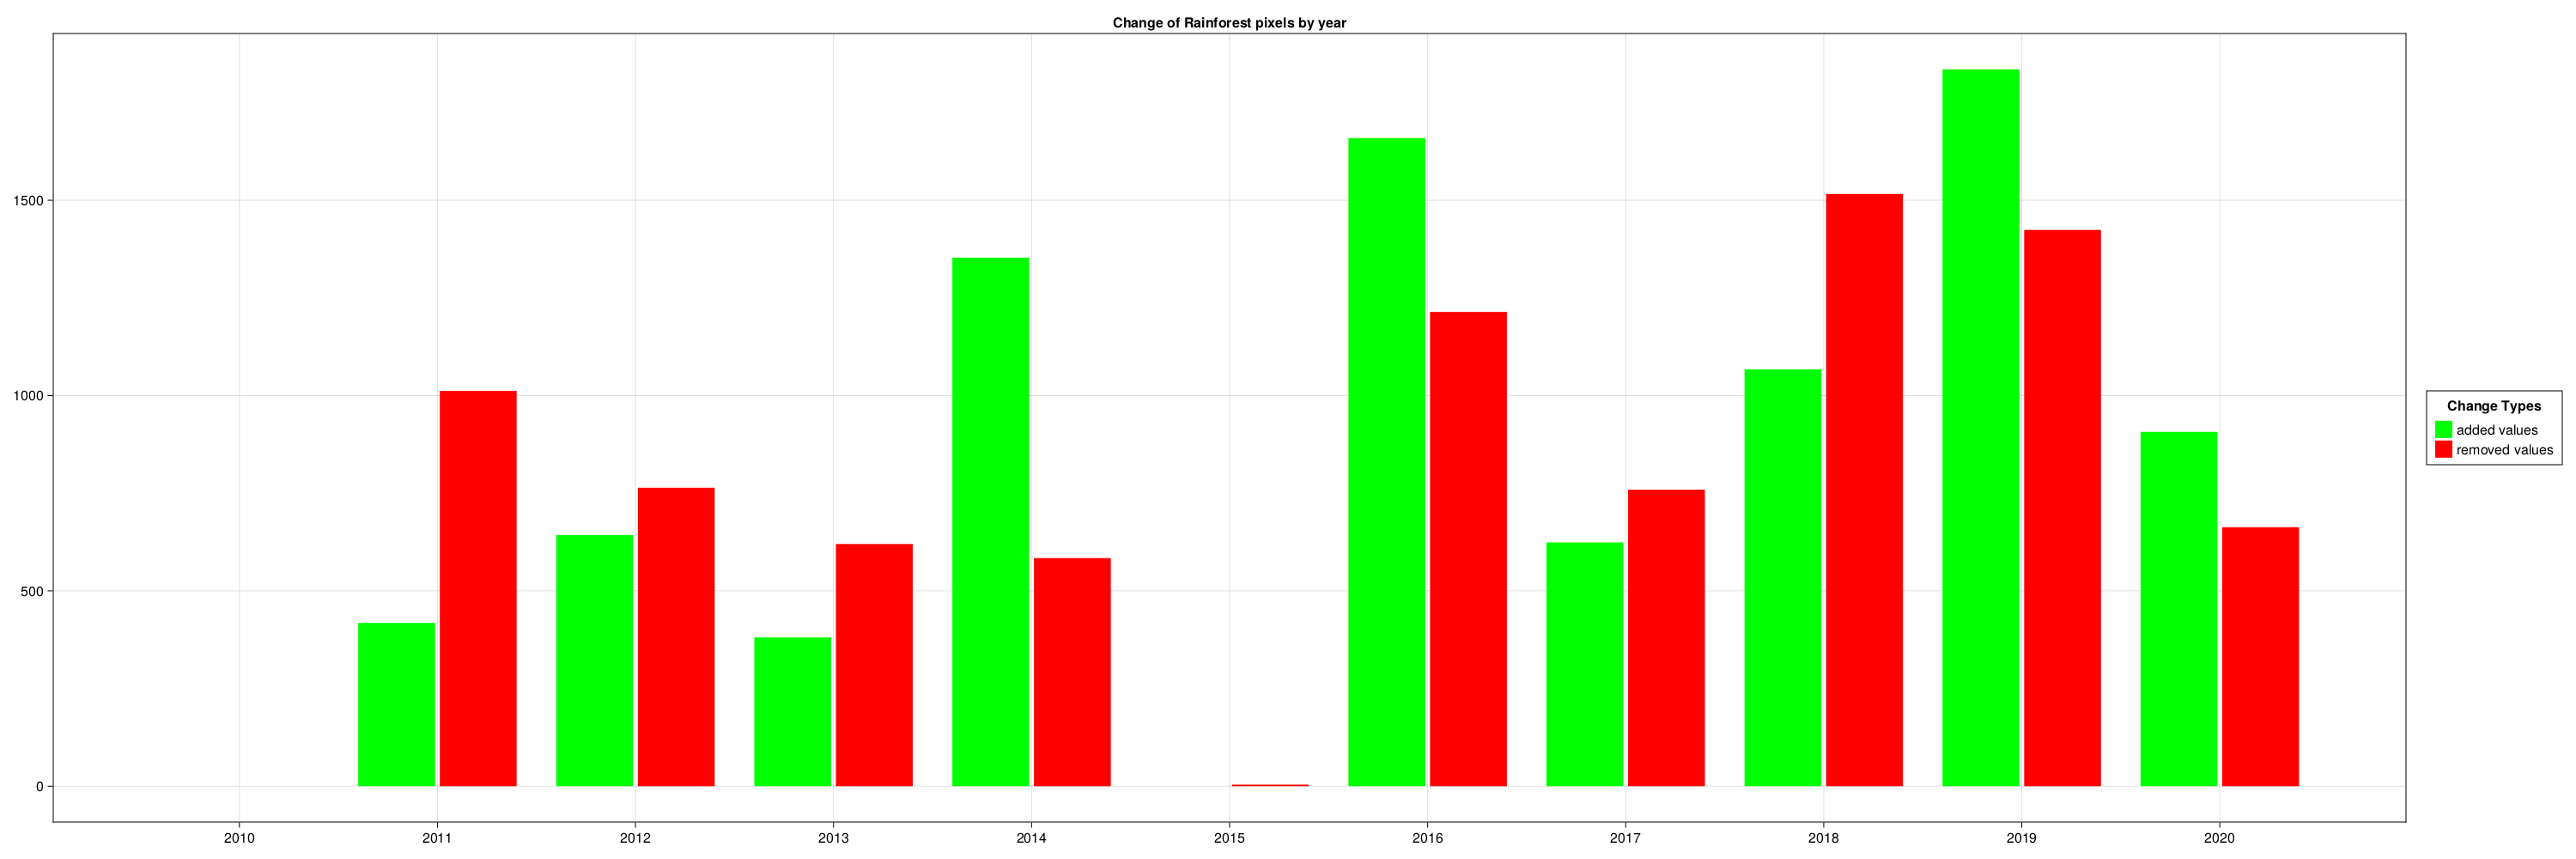

In [47]:
# build a bar chart with rainforest changes
Rainforestlib.rainforest_diff_over_time(filtered_dc, Rainforestlib.LCCSClasses.categories["rainforest"]; resolution = (3000, 1000), gradual_diff = true)
